Loading bitstream to FPGA

In [1]:
from pynq import Overlay
from pynq import Xlnk
import pynq.lib.dma

import cv2
import numpy as np
from matplotlib import pyplot as plt

import time

overlay = Overlay('canny.bit')
#overlay?

dma_send = overlay.axi_dma_ps2pl
dma_recv = overlay.axi_dma_pl2ps

/usr/local/lib/python3.6/dist-packages/pynq/pl_server/device.py:594: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)
/usr/local/lib/python3.6/dist-packages/pynq/lib/dma.py:200: UserWarning: Failed to find parameter c_sg_length_width; users should really use *.hwh files for overlays.
  warnings.warn(message, UserWarning)


Reading and processing image

(704, 1279)


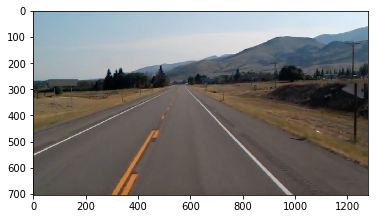

In [3]:
img = cv2.imread('test_image.png') # always read as BGR

h, w, d = img.shape

b, g, r = cv2.split(img)

rgb = np.zeros([h,w],dtype=np.uint32)
print(rgb.shape)

rgb[0:h,0:w] = 65536 * r[0:h,0:w] + 256 * g[0:h,0:w] + b[0:h,0:w];


xlnk = Xlnk()
input_buffer = xlnk.cma_array(shape=(h,w), dtype=np.uint32)

output_buffer = xlnk.cma_array(shape=(h,w), dtype=np.uint32)

input_buffer[0:h,0:w] = rgb[0:h,0:w]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Processing the image on FPGA (Applying Canny filter)

In [4]:
dma_send.sendchannel.transfer(input_buffer)
dma_recv.recvchannel.transfer(output_buffer)
dma_send.sendchannel.wait()
dma_recv.recvchannel.wait()

In [6]:
canny = np.zeros([h,w],dtype=np.uint8)
canny[0:h,0:w] =  output_buffer[0:h,0:w] & 255

Defining the regionn of interest

In [7]:
height = canny.shape[0] 
polygons = np.array([[(200, height), (1100, height), (550, 250)]]) 
mask = np.zeros_like(canny) 
      
    # Fill poly-function deals with multiple polygon 
cv2.fillPoly(mask, polygons, 255)  
      
    # Bitwise operation between canny image and mask image 
masked_image = cv2.bitwise_and(canny, mask)  

In [8]:
def create_coordinates(image, line_parameters): 
    slope, intercept = line_parameters 
    y1 = image.shape[0] 
    y2 = int(y1 * (3 / 5)) 
    x1 = int((y1 - intercept) / slope) 
    x2 = int((y2 - intercept) / slope) 
    return np.array([x1, y1, x2, y2]) 

Detecting the lanes

In [9]:
lines = cv2.HoughLinesP(masked_image, 2, np.pi / 180, 100, np.array([]), minLineLength = 40, maxLineGap = 5) 
line_image = np.zeros_like(img) 
left_fit = [] 
right_fit = [] 
for line in lines: 
    x1, y1, x2, y2 = line.reshape(4) 
          
    # It will fit the polynomial and the intercept and slope 
    parameters = np.polyfit((x1, x2), (y1, y2), 1)  
    slope = parameters[0] 
    intercept = parameters[1] 
    if slope < 0: 
        left_fit.append((slope, intercept)) 
    else: 
        right_fit.append((slope, intercept)) 
              
left_fit_average = np.average(left_fit, axis = 0) 
right_fit_average = np.average(right_fit, axis = 0) 
left_line = create_coordinates(img, left_fit_average) 
right_line = create_coordinates(img, right_fit_average)

ly = np.array([left_line, right_line]) 
if ly is not None: 
    for x1, y1, x2, y2 in ly: 
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 10) 

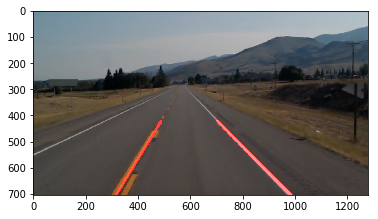

In [11]:
combo_image = cv2.addWeighted(img, 0.8, line_image, 1, 1)  
plt.imshow(cv2.cvtColor(combo_image, cv2.COLOR_BGR2RGB)) 

## Resources used:

* URL:"https://www.geeksforgeeks.org/opencv-real-time-road-lane-detection/" $\;\;\;$ Author: Dolly_Vaishnav